In [ ]:
import csv, os, glob, torch, time
from tqdm import tqdm
from utils.module import write_to_csv
from utils.autoencoder import VAE, vae_loss
from dataloader.dataset import UnlabeledDataset2, UnlabeledTransform2
import torch.utils.data as data
from utils.module import EarlyStopping
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [ ]:
!nvidia-smi

In [ ]:
class CenterCropTransform():
    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, image):
        image = transforms.CenterCrop((self.crop_size, self.crop_size))(image)

        # テンソルに変換
        image = transforms.ToTensor()(image)

        return image

In [ ]:
img_file_path = sorted(glob.glob('data/Train/images/*'))
img_file_path2 = sorted(glob.glob('data/original_split_resized/*'))
img_list = img_file_path + img_file_path2

train_dataset = UnlabeledDataset2(
    img_list, transform=CenterCropTransform(crop_size=32))
train_dataloader = data.DataLoader(
    train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

In [ ]:
# train_dataloaderから次のバッチを取得
data_iterator = iter(train_dataloader)
imgs = next(data_iterator)

# バッチ内の最初の画像を取得
single_image = imgs[0]

# 画像をNumPy配列に変換
single_image = single_image.numpy()

# 画像をMatplotlibで表示
plt.imshow(single_image.transpose(1, 2, 0))  # チャンネルの次元を最後に移動
plt.show()


In [ ]:
# VAEモデルのインスタンス化
model = VAE(latent_dim=50)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# オプティマイザを定義
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Epochs
num_epochs = 1000

In [ ]:
project = 'vae50'
earlystopping = EarlyStopping(patience=50)
os.makedirs('weights/'+ project, exist_ok=True)
# model.load_state_dict(torch.load('weights/vae2/best.pth'))
model = model.to(device)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # モデルをトレーニングモードに設定
    running_loss = 0.0

    for inputs in tqdm(train_dataloader):
        inputs = inputs.to(device)
        optimizer.zero_grad()  # 勾配をゼロに初期化
        outputs, mu, logvar, z = model(inputs)  # フォワードパス
        loss = vae_loss(outputs, inputs, mu, logvar)  # 損失を計算
        loss.backward()  # 逆伝播
        optimizer.step()  # パラメータを更新
        running_loss += loss.item()
    
    epoch_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")

    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    with torch.no_grad():
        # Early Stopping
        earlystopping(epoch_train_loss)

        if earlystopping.early_stop:
            print("Early stopping")
            break
        if earlystopping.counter == 0:
            # download to CPU
            torch.save(model.to('cpu').state_dict(), 'weights/'+ project + '/best.pth')
            # upload to GPU
            model = model.to(device)

        print(f'Early Stopping Counter = {earlystopping.counter}')

torch.save(model.to('cpu').state_dict(), 'weights/'+ project + '/last.pth')

In [10]:
def encode(img_path, model):
    image = Image.open(img_path)

    # 画像を指定された形状にリサイズ
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()  # Tensorに変換
    ])
    image = transform(image)

    # バッチ次元を追加
    image = image.unsqueeze(0)
    
    output, _, _, z = model(image)
    
    return image, output, z

tensor([[ 0.9330, -1.7219,  0.0278,  0.7976, -0.6196, -0.6633, -0.8612,  2.7045,
          0.1479, -0.0167, -1.1183,  0.3337,  0.6600,  0.3850, -0.2391, -0.0722,
          1.2080, -1.3918,  1.6010,  0.7459,  1.6336,  0.8534,  2.0785, -2.0615,
          1.2727,  0.7908, -0.2665, -0.3700,  0.0989, -0.6152, -1.2087,  1.7239,
          1.9450,  3.6195,  0.6019, -0.1249,  0.4736, -0.6786, -0.5184,  0.3474,
          0.9116, -0.5906,  1.2462,  0.1025,  0.6326,  0.0905,  0.1305,  0.8578,
          0.3775, -0.6255]])


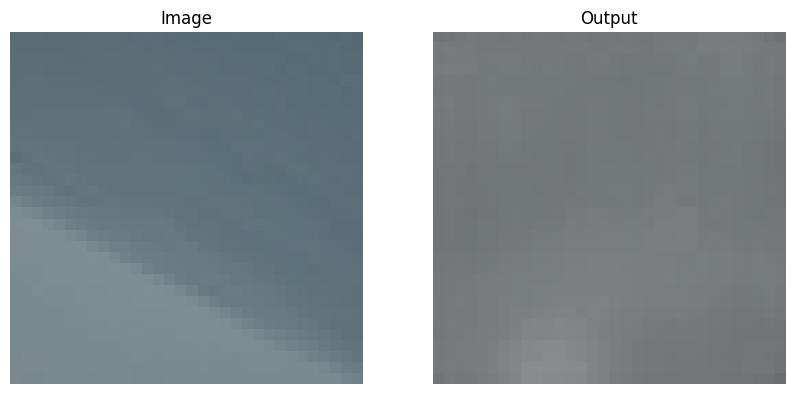

In [15]:
model = VAE(latent_dim=50)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('weights/vae50/best.pth'))
model = model.to(device)

img_path = "data/Train/images/Volker_DSC01611_102_962_1355_1128.jpg"
image, output, z = encode(img_path, model)
output = output.cpu().detach()
print(z.cpu().detach())

# 1行2列のサブプロットを作成
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# imageを表示
image = image.squeeze(0).numpy().transpose(1, 2, 0)  # バッチ次元を削除し、チャンネルの次元を最後に移動
axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis('off')

# outputを表示
output = output.squeeze(0).numpy().transpose(1, 2, 0)  # バッチ次元を削除し、チャンネルの次元を最後に移動
axes[1].imshow(output)
axes[1].set_title("Output")
axes[1].axis('off')

plt.show()

In [ ]:
# SourceとTargetから500サンプルずつ潜在変数に変換してプロット
import random
source_file_path = sorted(glob.glob('data/Train/images/*'))
random.shuffle(source_file_path)
target_file_path = sorted(glob.glob('data/original_split_resized/*'))
random.shuffle(target_file_path)

source_z_list = []
target_z_list = []

model = VAE(latent_dim=2)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('weights/vae2/best.pth'))
model = model.to(device)

for i in range(500):
    _, _, z = encode(source_file_path[i], model)
    z = z.cpu().detach().squeeze(0).numpy()
    source_z_list.append(z)
    
for i in range(500):
    _, _, z = encode(target_file_path[i], model)
    z = z.cpu().detach().squeeze(0).numpy()
    target_z_list.append(z)    

# listには500個の2次元numpy配列が格納されている
# sourceとtargetの座標をプロット
plt.scatter(*zip(*source_z_list), label='Source', c='blue', marker='o')
plt.scatter(*zip(*target_z_list), label='Target', c='red', marker='x')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Plot latent variable')
plt.grid(True)
plt.show()